In [1]:
import sys
import os

path = os.path.abspath(".")
sys.path.insert(0, os.path.dirname(path))

In [2]:
sys.path

['/gwpool/users/gpizzati/test_processor/my_processor',
 '/gwpool/users/gpizzati/test_processor/my_processor/notebooks',
 '/gwpool/users/gpizzati/mambaforge/envs/test_uproot/lib/python310.zip',
 '/gwpool/users/gpizzati/mambaforge/envs/test_uproot/lib/python3.10',
 '/gwpool/users/gpizzati/mambaforge/envs/test_uproot/lib/python3.10/lib-dynload',
 '',
 '/gwpool/users/gpizzati/mambaforge/envs/test_uproot/lib/python3.10/site-packages']

In [3]:
import matplotlib.pyplot as plt
import vector

vector.register_awkward()

In [4]:
import awkward as ak
import numpy as np
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory

In [5]:
from framework import read_events, read_chunks

In [6]:
chunks = read_chunks("../condor/job_0/chunks_job.pkl")

In [7]:
events = read_events(
    **{k: v for k, v in chunks[1].items() if k != "dataset" and k != "xs"}
)

start reading
created events


In [8]:
import json

with open("../data/cfg.json") as file:
    cfg = json.load(file)

In [9]:
from modules.jme import getJetCorrections

In [10]:
from modules.jme import correct_jets

In [11]:
from modules.jet_sel import jetSel

In [12]:
jec_stack = getJetCorrections(cfg)

In [13]:
events = jetSel(events)

In [14]:
originalEvents = ak.copy(events)

In [13]:
events[("Jet", "trueGenJetIdx")] = ak.mask(
    events.Jet.genJetIdx,
    (events.Jet.genJetIdx >= 0) & (events.Jet.genJetIdx < ak.num(events.GenJet)),
)
name_map = jec_stack.blank_name_map
name_map["JetPt"] = "pt"
name_map["JetMass"] = "mass"
name_map["JetEta"] = "eta"
name_map["JetA"] = "area"

jets = events.Jet

jets["pt_raw"] = (1 - jets["rawFactor"]) * jets["pt"]
jets["mass_raw"] = (1 - jets["rawFactor"]) * jets["mass"]
jets["pt_gen"] = ak.values_astype(
    ak.fill_none(events.GenJet[events.Jet.trueGenJetIdx].pt, 0), np.float32
)
jets["rho"] = ak.broadcast_arrays(events.fixedGridRhoFastjetAll, jets.pt)[0]
name_map["ptGenJet"] = "pt_gen"
name_map["ptRaw"] = "pt_raw"
name_map["massRaw"] = "mass_raw"
name_map["Rho"] = "rho"
print(jets[ak.num(jets) >= 2].pt)

jet_factory = CorrectedJetsFactory(name_map, jec_stack)

corrected_jets = jet_factory.build(jets).compute()

[[36.3, 25.9, 18.2, 16.7, 15.2], [22.1, ...], ..., [42.9, 31.4, 18.7, 16.7, 16]]


In [46]:
events = ak.copy(originalEvents)

In [47]:
import modules.jme

In [48]:
import importlib

importlib.reload(modules.jme)

<module 'modules.jme' from '/gwpool/users/gpizzati/test_processor/my_processor/modules/jme.py'>

In [49]:
variations = {}
variations["nom"] = [()]
events, variations = modules.jme.correct_jets(events, variations, jec_stack)

[[36.3, 25.9, 18.2, 16.7, 15.2], [22.1, ...], ..., [42.9, 31.4, 18.7, 16.7, 16]]
[[36.3, 25.9, 18.2, 16.7, 15.2], [22.1, ...], ..., [42.9, 31.4, 18.7, 16.7, 16]]
[[36.3, 25.9, 18.2, 16.7, 15.2], [22.1, ...], ..., [42.9, 31.4, 18.7, 16.7, 16]]
['JES_RelativeSample_2018', 'JES_EC2', 'JES_Total', 'JES_EC2_2018', 'JES_Absolute_2018', 'JES_HF', 'JES_BBEC1_2018', 'JER', 'JES_FlavorQCD', 'JES_RelativeBal', 'JES_HF_2018', 'JES_Absolute', 'JES_BBEC1']


Doing variations


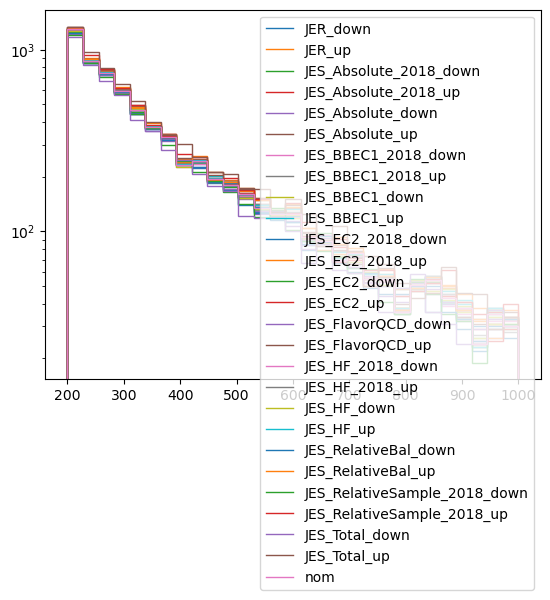

In [50]:
histos = {}
originalEvents2 = ak.copy(events)
bins = np.linspace(200, 1000, 30)
edges = bins.copy()
x = (bins[1:] + bins[:-1]) / 2
print("Doing variations")
for variation in sorted(list(variations.keys())):
    events = ak.copy(originalEvents2)

    for switch in variations[variation]:
        if len(switch) == 2:
            variation_dest, variation_source = switch
            # variation_backup = get_backup_column(variation_dest)
            # events[variation_backup] = ak.copy(events[variation_dest])
            events[variation_dest] = events[variation_source]

    # resort Jets
    jet_sort = ak.argsort(events[("Jet", "pt")], ascending=False, axis=1)
    events["Jet"] = events.Jet[jet_sort]

    events["Jet"] = events.Jet[events.Jet.pt >= 30]
    events = events[(ak.num(events.Jet, axis=1) >= 2)]
    events["mjj"] = (events.Jet[:, 0] + events.Jet[:, 1]).mass

    h = np.histogram(events.mjj.to_numpy(), bins=bins)[0]
    histos[variation] = h.copy()
    plt.stairs(h, edges, label=variation)

    """
    for switch in variations[variation]:
        if len(switch) == 2:
            variation_dest, variation_source = switch
            variation_backup = get_backup_column(variation_dest)
            events[variation_dest] = events[variation_backup]
    """

plt.yscale("log")
plt.legend()

In [51]:
variation_names = ["JES_FlavorQCD", "JES_RelativeBal", "JES_RelativeSample_2018"]
variation_names += [
    variation + suffix
    for variation in ["JES_Absolute", "JES_BBEC1", "JES_EC2", "JES_HF"]
    for suffix in ["", "_2018"]
]
variation_names += ["JES_Total"]
variation_names += ["JER"]
variation_names

['JES_FlavorQCD',
 'JES_RelativeBal',
 'JES_RelativeSample_2018',
 'JES_Absolute',
 'JES_Absolute_2018',
 'JES_BBEC1',
 'JES_BBEC1_2018',
 'JES_EC2',
 'JES_EC2_2018',
 'JES_HF',
 'JES_HF_2018',
 'JES_Total',
 'JER']

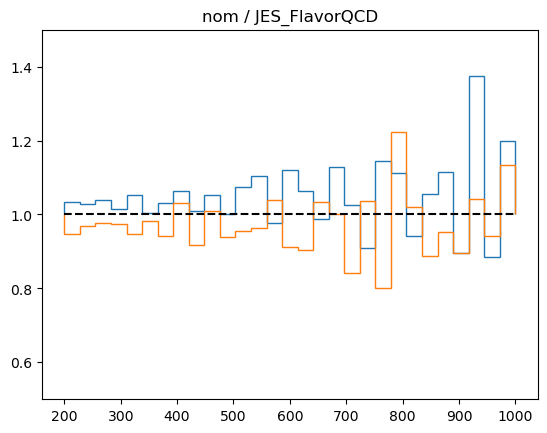

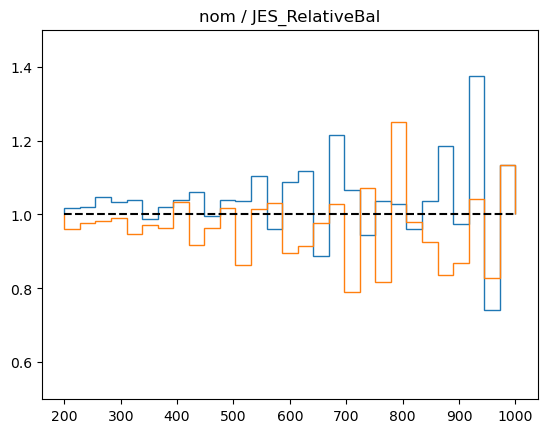

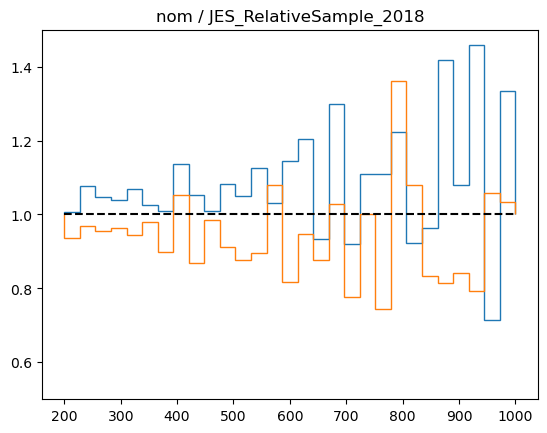

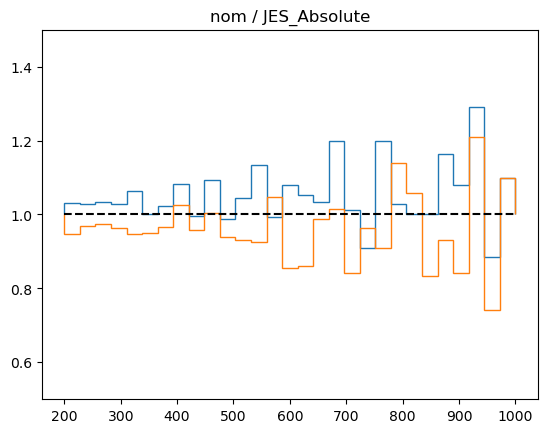

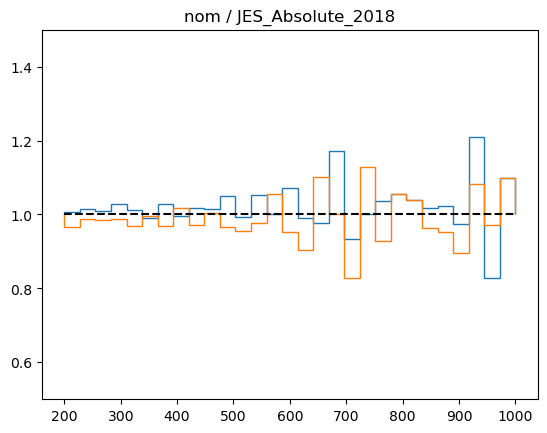

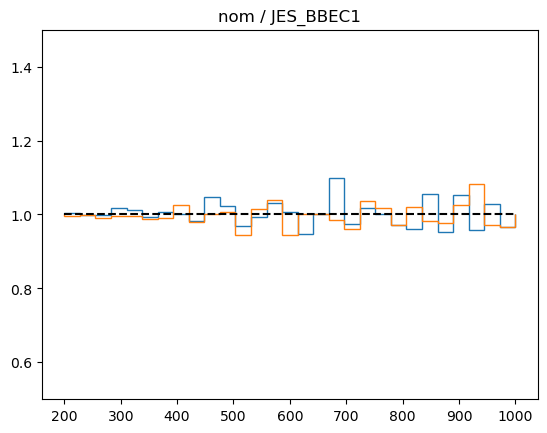

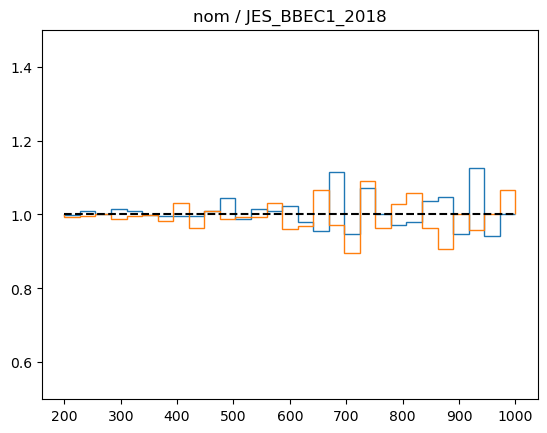

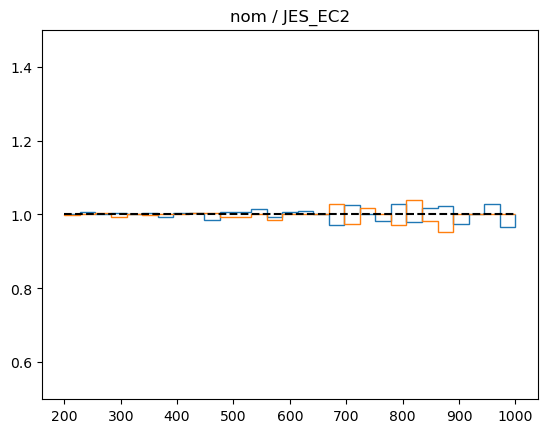

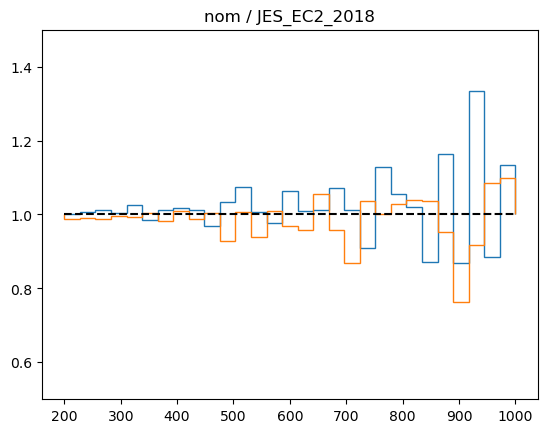

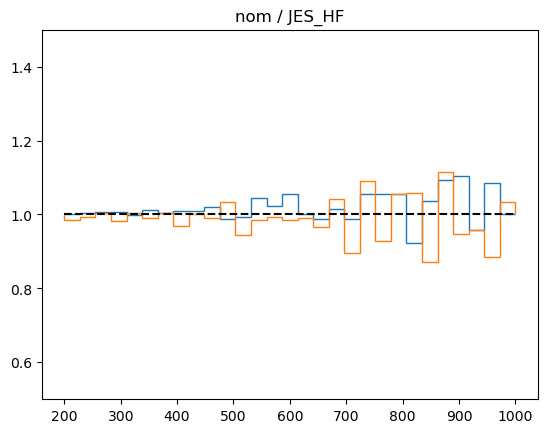

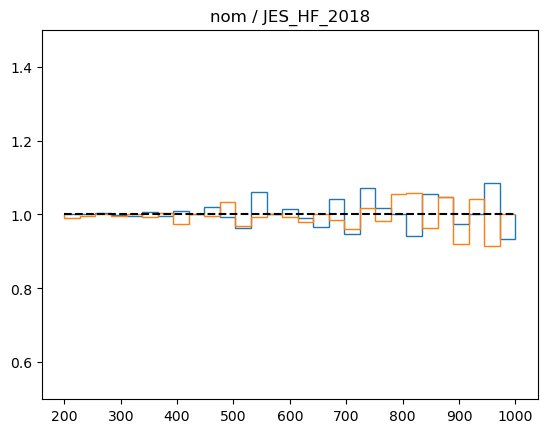

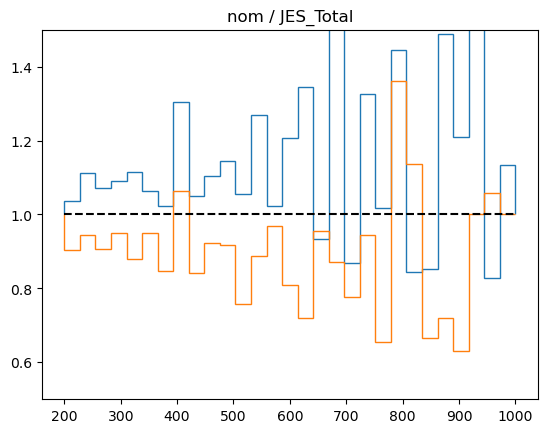

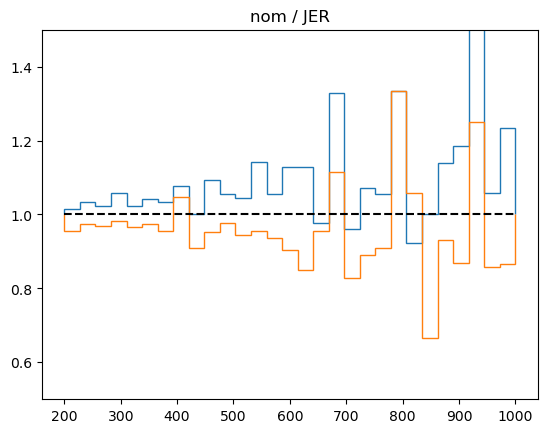

In [52]:
# for histo in histos:
for variation in variation_names:
    plt.figure()
    plt.title("nom / " + variation)
    plt.stairs(histos[f"{variation}_up"] / histos["nom"], edges, baseline=1.0)
    plt.stairs(histos[f"{variation}_down"] / histos["nom"], edges, baseline=1.0)
    plt.ylim(0.5, 1.5)
    plt.plot(edges, np.ones_like(edges), color="black", linestyle="dashed")

    # ratio = histos['nom']/histos[histo]
    # plt.errorbar(x, ratio, fmt='.')
    # plt.plot(edges, np.ones_like(edges), color='black', linestyle='dashed')
    # plt.ylim(0.5,1.5)
# plt.legend()